In [1]:
from tqdm import tqdm
import os
import re
import tifffile as tif

import utils.analysis as analysis
import utils.datautils as datautils

import numpy as np
from skimage.measure import regionprops, marching_cubes, mesh_surface_area, perimeter
import pandas as pd
import math
from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
# import seaborn as sns
%matplotlib inline

from timeit import default_timer as timer
from multiprocessing import cpu_count, Process, Pool

In [2]:
#  input and save paths
data_path = '/home/tli_project/Desktop/Data/T4/neurons/all/'
# save_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeA/output/'
start_age = 37

In [3]:
# getting list of masked_images files
files_list = datautils.get_file_names(data_path, group_by='', 
                                    order=True, nested_files=False, 
                                    criteria='')

first 5 files
['/home/tli_project/Desktop/Data/T4/neurons/all/220209_P36_N2_FlipV_R255_mask1.tif', '/home/tli_project/Desktop/Data/T4/neurons/all/220209_P36_N1_FlipV_R270_JE_mask.tif', '/home/tli_project/Desktop/Data/T4/neurons/all/220127_P36_N1_R240_JE_mask.tif', '/home/tli_project/Desktop/Data/T4/neurons/all/211121_P36.5_N3_R290_JE_mask.tif', '/home/tli_project/Desktop/Data/T4/neurons/all/211121_P36.5_N2_R302_mask.tif']


In [4]:
all_neurons = {}
for neu_path in tqdm(files_list):
    neu_name = os.path.basename(neu_path)
    neu_name = neu_name[:neu_name.index('N')+2]
    start_im = re.search('P(.*)_N', neu_path)
    start_im = float(start_im.group(1))
    start_ana = int((start_age - start_im)/0.25)
    neuron = tif.imread(neu_path)
    neuron = neuron[start_ana:] #remove timepoints before start_ana from the 4D image array
    neuron[neuron != 0] = 1
    lifetimes = analysis.cal_lifetimes(neuron, save=False)
    # lifetimes = lifetimes[-1].astype(float)
    # lifetimes[lifetimes>0] = 37+0.25*(lifetimes.max()-lifetimes[lifetimes>0])
    all_neurons[neu_name] = lifetimes[-1]

100%|██████████| 18/18 [02:39<00:00,  8.89s/it]


In [14]:
subset = {}
for neu, stack in all_neurons.items():
    image = stack.astype('int16')
    test_region = regionprops(image)[0]
    img_PC = np.argwhere(image)
    centroid = np.array(test_region.centroid)
    centroid = np.rint(centroid) - (30, 250,250)
    img_PC = img_PC - centroid

    img_PC = np.insert(img_PC, 3, image[image>0], axis=1)
    # img_PC[:,-1] = 37+0.25*(img_PC[:,-1].max()-img_PC[:,-1])
    img_PC = img_PC.astype('int16')

    image = np.zeros((60,500,500))
    for px in img_PC:
        image[px[0],px[1],px[2]] = px[-1]
    subset[neu] = image


In [29]:
subset_PC = {}
for neu, stack in all_neurons.items():
    image = stack.astype('int16')
    test_region = regionprops(image)[0]
    img_PC = np.argwhere(image)
    centroid = np.array(test_region.centroid)
    centroid = np.rint(centroid) - (30, 250,250)
    img_PC = img_PC - centroid

    img_PC = np.insert(img_PC, 3, image[image>0], axis=1)
    img_PC[:,-1] = 37+0.25*(img_PC[:,-1].max()-img_PC[:,-1])
    img_PC = img_PC.astype(float)

    image = np.zeros((60,500,500))
    for px in img_PC:
        z,y,x = int(px[0]), int(px[1]),int(px[2])
        image[z,y,x] = px[-1]
    subset_PC[neu] = img_PC

In [30]:
subset_PC['211104_P36_N1']

array([[ 11.  , 223.  , 239.  ,  57.75],
       [ 11.  , 223.  , 240.  ,  57.75],
       [ 11.  , 223.  , 241.  ,  57.75],
       ...,
       [ 48.  , 240.  , 310.  ,  58.  ],
       [ 48.  , 241.  , 308.  ,  58.  ],
       [ 48.  , 241.  , 309.  ,  58.  ]])

In [36]:
subset_PC['211104_P36_N1'][subset_PC['211104_P36_N1'][:,-1]==57.25].shape

(14047, 4)

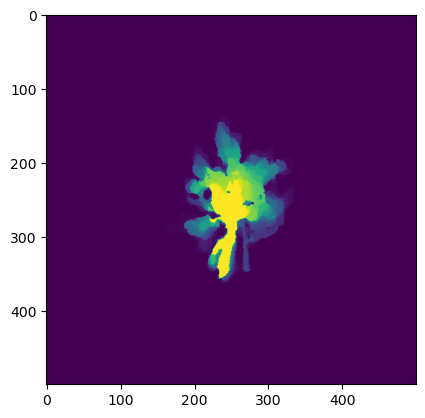

In [15]:
plt.imshow(subset['211104_P36_N1'].max(axis=0))

In [63]:

result = []
test2 = subset['211011_P37_N1'].copy()
y_range = np.arange(500)
for y in y_range:
    for x in y_range:
        curr = test2[:,y,x]
        if (curr.sum() > 0) and (curr.max() > curr[curr>0].min()) :
            result.append(curr)
            # print(curr)
# for z in subset['211104_P36_N1']:
#     if z.sum() != 0:
#         print()

In [64]:
test2.max()

85.0

In [65]:
result[1000]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 4., 5., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [43]:
result[500]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., 15., 15., 16., 16., 16., 27.,
       27., 30., 30., 36., 36., 36., 36., 36., 30., 30., 27.,  2.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [44]:
result[1500]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  3.,  7.,  8., 48., 48., 48.,
       48., 49., 49., 50., 50., 45., 45., 45., 45., 19., 16., 10.,  5.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

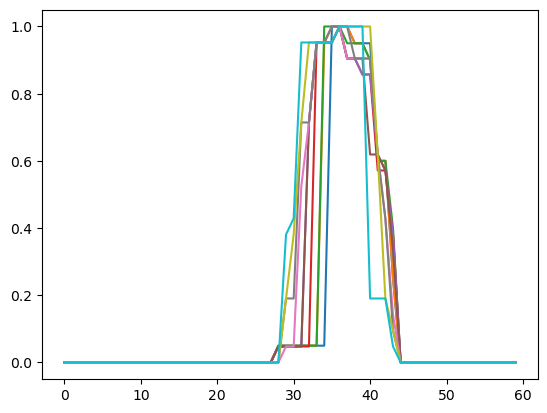

: 

In [69]:
for z, i in enumerate(result[1030:1040], 500):
    i_plot = i/i.max()
    plt.plot(i_plot)
# plt.legend()

In [83]:
from sklearn import metrics
def check_similarity(ref, image):
    check = sum(metrics.pairwise.cosine_similarity(image.ravel().reshape(1,-1), 
                           ref.ravel().reshape(1,-1)))[0]
    # print('check_similarity of image to ref is', check)
    return check

In [106]:
results_df = pd.DataFrame(columns=subset.keys())

In [107]:
for neu, stack in tqdm(subset.items()):
    neu_res = [check_similarity(stack, image) for image in subset.values()]
    results_df[neu] = neu_res

100%|██████████| 18/18 [00:24<00:00,  1.39s/it]


In [108]:
results_df.index = results_df.columns

In [113]:
from os import path
data_path = '/home/tli_project/Desktop/Data/T4/neurons/output/New/'
output_files = datautils.get_file_names(data_path, group_by='_', order=True, nested_files=False, criteria='.csv')
neu_types = {}
for neu in output_files:
    name = path.splitext(path.basename(neu))[0]
    subtype = name.split('_s')[1]
    name = name[:name.index('N')+2]
    neu_types[name] = subtype
neu_types = {'neu_type':list(neu_types.values()),'neu_name':list(neu_types.keys())}
neu_types = pd.DataFrame(neu_types)

first 5 files
['/home/tli_project/Desktop/Data/T4/neurons/output/New/220209_P36_N2_sA.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/220209_P36_N1_sC.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/220127_P36_N1_sD.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/211121_P36.5_N3_sC.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/211121_P36.5_N2_sA.csv']


In [114]:
neu_types = neu_types.sort_values(by=['neu_type'],ascending=True)
neu_types.index = neu_types['neu_name']

In [115]:
results_df = results_df.reindex(index=neu_types.neu_name, columns=neu_types.neu_name)

In [116]:
results_df

neu_name,220209_P36_N2,211104_P36_N2,211113_P36_N2,211114_P36_N2,211121_P36.5_N1,211114_P36_N1,211121_P36.5_N2,211107_P36_N1,211011_P37_N1,211114_P36_N3,211121_P36.5_N3,211104_P36_N1,211113_P36_N1,211107_P36_N2,211104_P36_N3,220209_P36_N1,220127_P36_N1,211107_P36_N3
neu_name,,,,,,,,,,,,,,,,,,
220209_P36_N2,1.000000,0.459074,0.448676,0.363275,0.369465,0.314170,0.435826,0.344398,0.166018,0.307164,0.399064,0.408215,0.356839,0.302244,0.346826,0.322197,0.367515,0.380887
211104_P36_N2,0.459074,1.000000,0.459331,0.421025,0.458294,0.492946,0.422259,0.440890,0.135551,0.318342,0.373127,0.374710,0.380906,0.300754,0.414552,0.321832,0.419343,0.336996
211113_P36_N2,0.448676,0.459331,1.000000,0.370730,0.409645,0.441511,0.398701,0.551280,0.193312,0.470566,0.437265,0.447148,0.475470,0.424370,0.421272,0.439718,0.449450,0.482339
211114_P36_N2,0.363275,0.421025,0.370730,1.000000,0.332057,0.344640,0.405132,0.349449,0.164059,0.319779,0.377975,0.390117,0.346491,0.290772,0.356945,0.391742,0.299979,0.282416
211121_P36.5_N1,0.369465,0.458294,0.409645,0.332057,1.000000,0.387442,0.471127,0.508744,0.163957,0.433786,0.384811,0.471698,0.579200,0.411844,0.402012,0.461283,0.422862,0.477097
211114_P36_N1,0.314170,0.492946,0.441511,0.344640,0.387442,1.000000,0.405986,0.398217,0.187856,0.401272,0.430183,0.320408,0.366318,0.342158,0.455255,0.355747,0.331341,0.347373
211121_P36.5_N2,0.435826,0.422259,0.398701,0.405132,0.471127,0.405986,1.000000,0.387239,0.174493,0.403981,0.490037,0.431678,0.417802,0.341195,0.472217,0.433741,0.371450,0.324858
211107_P36_N1,0.344398,0.440890,0.551280,0.349449,0.508744,0.398217,0.387239,1.000000,0.165968,0.445029,0.426741,0.427266,0.443867,0.319609,0.382516,0.404338,0.400564,0.492955
211011_P37_N1,0.166018,0.135551,0.193312,0.164059,0.163957,0.187856,0.174493,0.165968,1.000000,0.268554,0.209581,0.333569,0.260100,0.354774,0.272614,0.217934,0.244596,0.283925


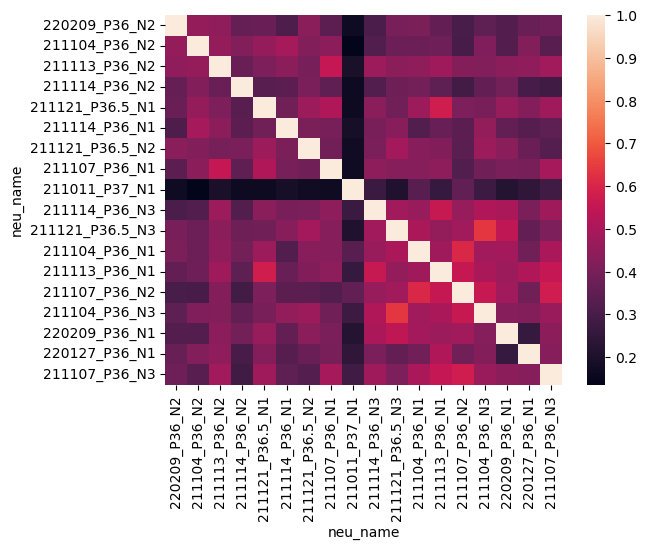

In [117]:
import seaborn as sns 

data = results_df

# plot heatmap
ax = sns.heatmap(data.T)

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)

# save figure
# plt.savefig('seabornPandas.png', dpi=100)
plt.show()

In [90]:
ref = subset['211104_P36_N2'].max(axis=0)
check_similarity(ref, subset['211113_P36_N2'].max(axis=0)), check_similarity(ref, subset['211011_P37_N1'].max(axis=0))

(0.6621929500177112, 0.29405849744744944)

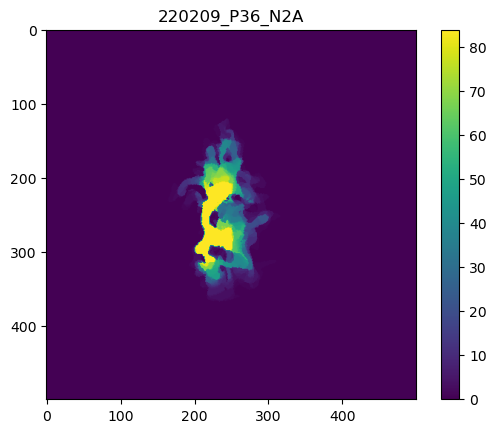

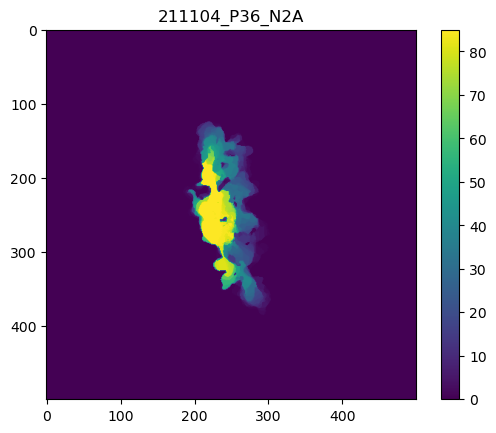

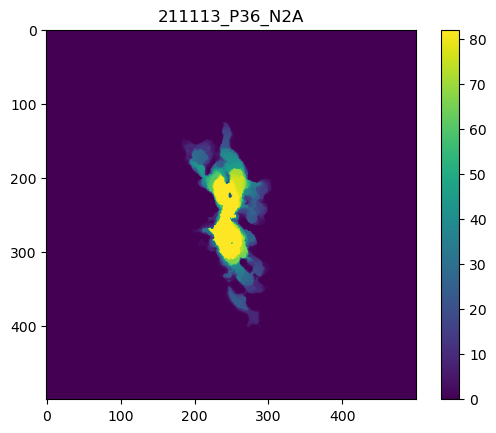

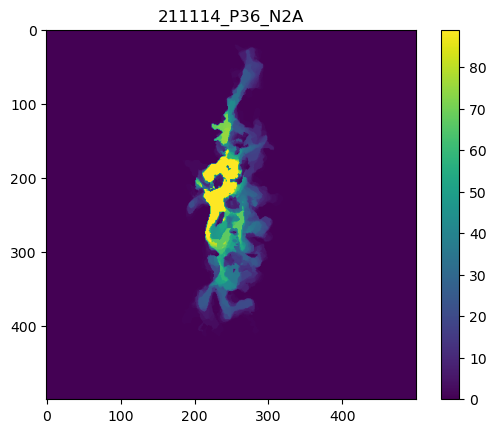

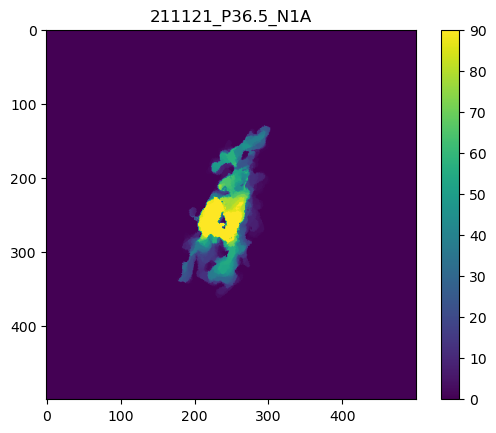

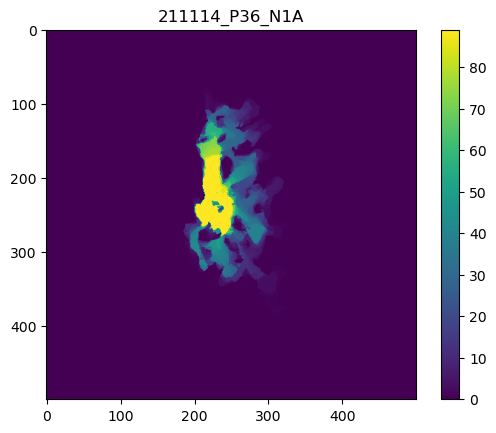

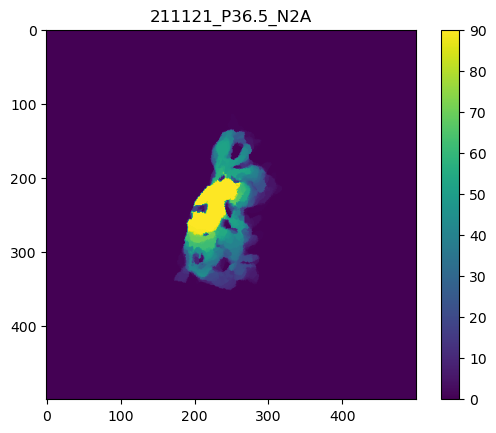

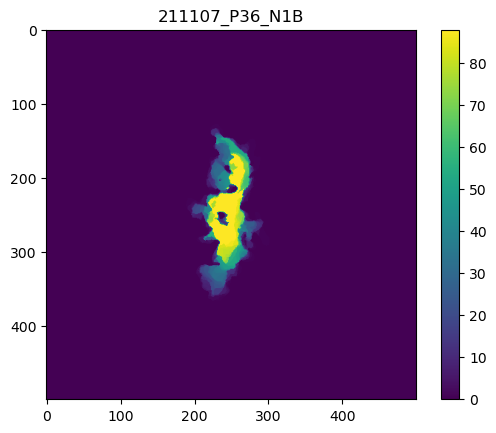

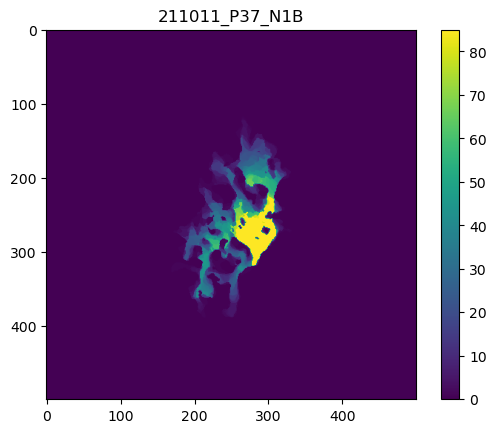

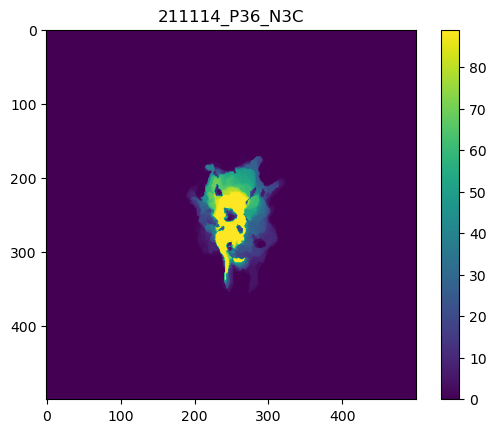

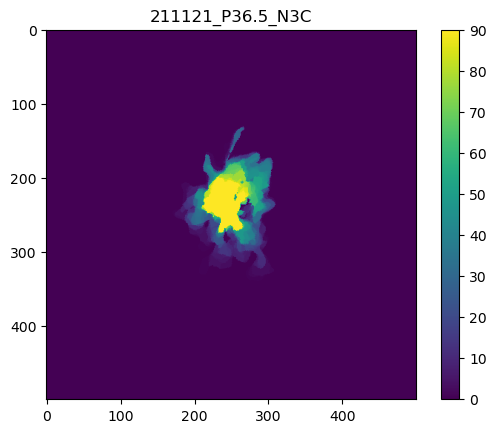

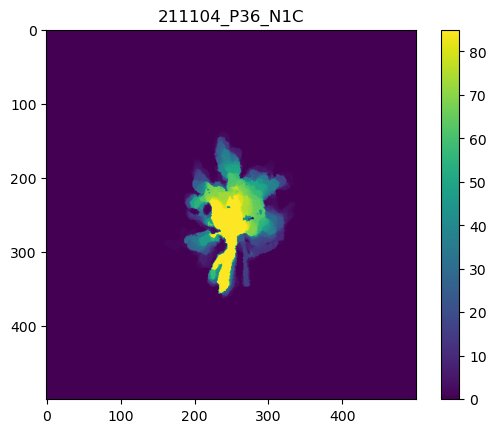

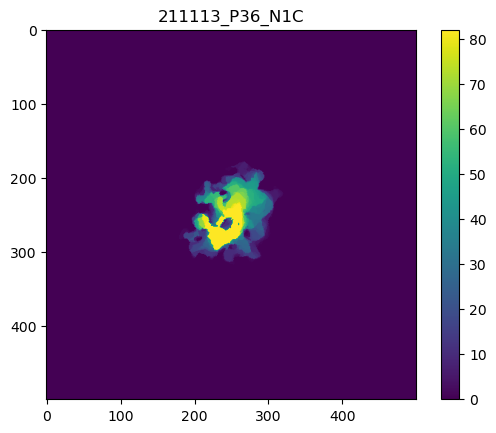

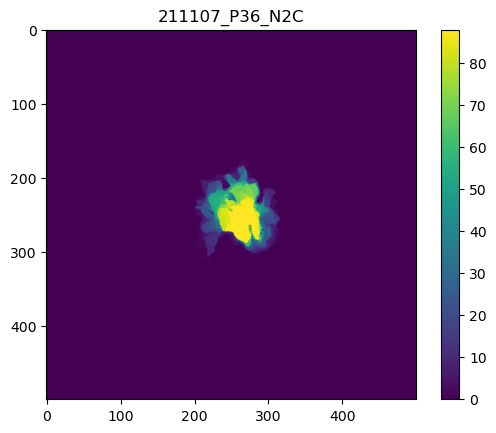

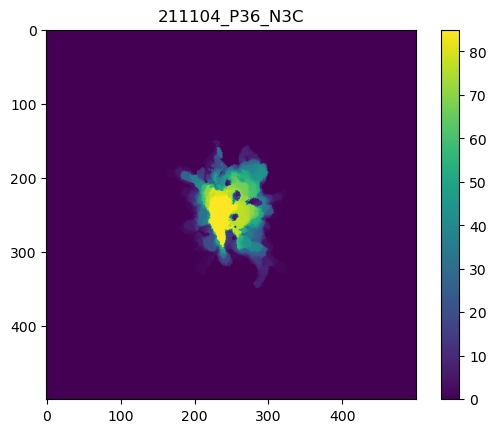

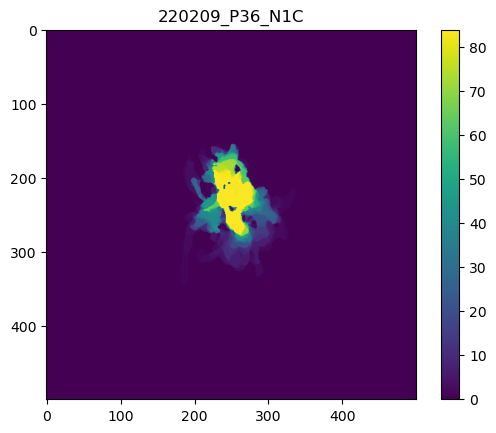

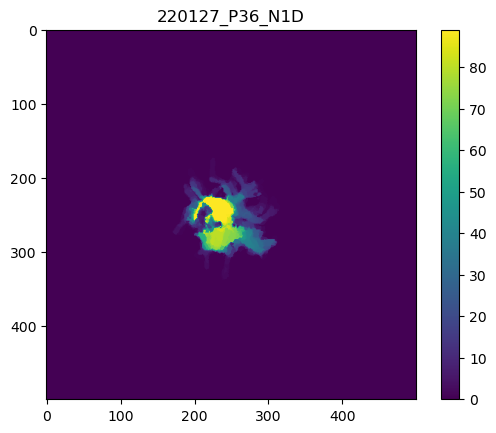

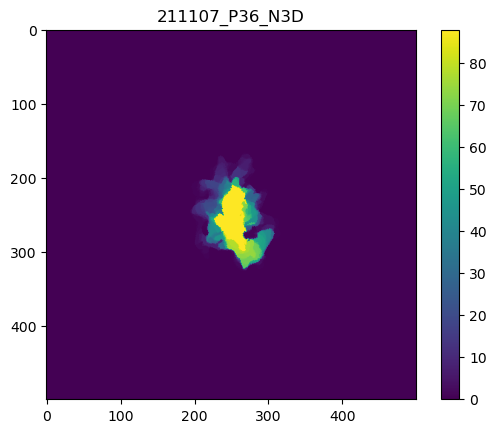

In [137]:
for i, neu in neu_types.iterrows():
    # print(neu.neu_name)
    img = subset[neu.neu_name].max(axis=0)
    fig, ax = plt.subplots(1)
    plt.title(neu.neu_name+neu.neu_type)
    im = ax.imshow(img)
    plt.colorbar(im)
    name = neu.neu_name+'_s'+neu.neu_type+'_lifetimes_@_end.png'
    # plt.savefig(name)

In [18]:
test = subset['211107_P36_N3'].copy()
# test[test!=0] = 37+0.25*(test.max()-test[test!=0])
test = test.astype('int16')
test_region = regionprops(test)[0]
img_PC = np.argwhere(test)
# img_PC = test_region.coords
centroid = np.array(test_region.centroid)
centroid = np.rint(centroid) - (30, 250,250)
img_PC = img_PC - centroid

img_PC = np.insert(img_PC, 3, test[test>0], axis=1)
img_PC[:,-1] = 37+0.25*(img_PC[:,-1].max()-img_PC[:,-1])

# img_PC = img_PC.astype('uint16')

# image = np.zeros((60,500,500))
# for px in img_PC:
#     image[px[0],px[1],px[2]] = px[-1]
# subset[neu] = image


# subset = {}
# for neu, stack in all_neurons.items():
#     image = stack[-1].astype('uint8')
#     img_PC = np.argwhere(image)
    
#     centroid = np.array(regionprops(image)[0].centroid)
#     centroid = np.rint(centroid) - (30, 250,250)
#     img_PC = img_PC - centroid
#     img_PC = np.insert(img_PC, 3, image[image>0], axis=1)
#     img_PC = img_PC.astype('uint16')

#     image = np.zeros((60,500,500))
#     for px in img_PC:
#         image[px[0],px[1],px[2]] = px[-1]
#     subset[neu] = image

In [19]:
img_PC[:,-1].max()

58.75

In [13]:
test.max()

88

In [16]:
37+0.25*(img_PC[:,-1].max()-img_PC[:,-1].min())

58.75

In [17]:
37+0.25*(test.max()-test[test!=0].min())

58.75

In [170]:
test = subset['211104_P36_N2'].copy().astype(float)
# test[test == 0] =  test.max() - 1
test = test  - test.max() - 1
test = test * -1


# plt.imshow(test.max(axis=0))

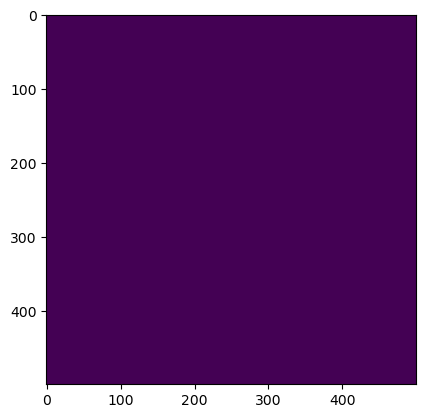

In [165]:
test = subset['211104_P36_N2'].copy()

# test[test==0] = 30
# test[test == 0] =  test.max() - 1
test = test.astype('int16')

test[test>0] = test[test>0]  - (test.max() +1)
test = test * -1
# plt.hist(np.ravel(test[test>0]))

# print(test.max(), test.min())
plt.imshow(np.median(test, axis=0))

In [147]:
test[test>0] = test[test>0] - (test.max()-1)
print(test.max())

1.0


In [74]:
test.min()

-84.0

In [90]:
image[px[0],px[1],px[2]]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [85]:
img_PC[0].min()

7.0

In [24]:
image = (stack[-1]*4).astype('uint8')
test = regionprops(image)

In [34]:
all_neurons['220209_P36_N2'][6].max()

57.75

In [5]:
for neu, stack in all_neurons.items():
    


{'220209_P36_N2_FlipV_R255_mask1.tif': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
  